In [1]:
import glob

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
imgs = glob.glob("../input/Flickr8k/Images/*.jpg")

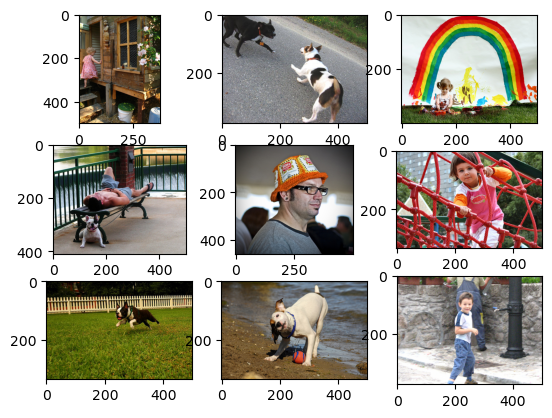

In [3]:
for i in range(9):
    img = Image.open(imgs[i])
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)

plt.show()

# 학습용 데이터셋 만들기

In [4]:
import cv2
import numpy as np
from torch.utils.data.dataset import Dataset

In [5]:
def rgb2lab(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)


def lab2rgb(lab):
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

In [6]:
class AutoColoring(Dataset):
    def __init__(self):
        self.data = glob.glob("../input/Flickr8k/Images/*.jpg")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        rgb = np.array(Image.open(self.data[i]).resize((256, 256)))
        lab = rgb2lab(rgb)
        # 차원을 (H, W, C) -> (C, H, W)로 변경
        lab = lab.transpose((2, 0, 1)).astype(np.float32)

        return lab[0], lab[1:]

# 모델 정의하기

## 로 레벨 특징 추출기

In [7]:
import torch
import torch.nn as nn

In [8]:
class LowLevel(nn.Module):
    def __init__(self):
        super(LowLevel, self).__init__()

        self.low1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
        self.lb1 = nn.BatchNorm2d(64)

        self.low2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.lb2 = nn.BatchNorm2d(128)

        self.low3 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.lb3 = nn.BatchNorm2d(128)

        self.low4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.lb4 = nn.BatchNorm2d(256)

        self.low5 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.lb5 = nn.BatchNorm2d(256)

        self.low6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.lb6 = nn.BatchNorm2d(512)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        low = self.low1(x)
        low = self.lb1(low)
        low = self.sigmoid(low)

        low = self.low2(low)
        low = self.lb2(low)
        low = self.sigmoid(low)

        low = self.low3(low)
        low = self.lb3(low)
        low = self.sigmoid(low)

        low = self.low4(low)
        low = self.lb4(low)
        low = self.sigmoid(low)

        low = self.low5(low)
        low = self.lb5(low)
        low = self.sigmoid(low)

        low = self.low6(low)
        low = self.lb6(low)
        low = self.sigmoid(low)

        return low

## 미들 레벨 특징 추출기

In [9]:
class MidLevel(nn.Module):
    def __init__(self):
        super(MidLevel, self).__init__()

        self.mid1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.mb1 = nn.BatchNorm2d(512)

        self.mid2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.mb2 = nn.BatchNorm2d(256)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mid = self.mid1(x)
        mid = self.mb1(mid)
        mid = self.sigmoid(mid)

        mid = self.mid2(mid)
        mid = self.mb2(mid)
        mid = self.sigmoid(mid)

        return mid

## 글로벌 레벨 특징 추출기

In [10]:
class GlobalLevel(nn.Module):
    def __init__(self):
        super(GlobalLevel, self).__init__()

        self.glob1 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.gb1 = nn.BatchNorm2d(512)

        self.glob2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.gb2 = nn.BatchNorm2d(512)

        self.glob3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.gb3 = nn.BatchNorm2d(512)

        self.glob4 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.gb4 = nn.BatchNorm2d(512)

        # 글로벌 레벨 특징 추출기의 MLP 층
        # 분류기로 사용되는 게 아닌 색을 칠하기 위해 사용하는 특징으로 사용
        self.fc1 = nn.Linear(in_features=32768, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=256)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        glo = self.glob1(x)
        glo = self.gb1(glo)
        glo = self.sigmoid(glo)

        glo = self.glob2(glo)
        glo = self.gb2(glo)
        glo = self.sigmoid(glo)

        glo = self.glob3(glo)
        glo = self.gb3(glo)
        glo = self.sigmoid(glo)

        glo = self.glob4(glo)
        glo = self.gb4(glo)
        glo = self.sigmoid(glo)

        # 합성곱을 통해 추출된 특징을 1차원으로 펼치기
        glo = torch.flatten(glo, start_dim=1)
        glo = self.fc1(glo)
        glo = self.sigmoid(glo)
        glo = self.fc2(glo)
        glo = self.sigmoid(glo)
        glo = self.fc3(glo)
        glo = self.sigmoid(glo)

        return glo

## 컬러라이제이션 신경망

In [11]:
class Colorization(nn.Module):
    def __init__(self):
        super(Colorization, self).__init__()

        self.color1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.cb1 = nn.BatchNorm2d(128)

        self.color2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.cb2 = nn.BatchNorm2d(64)

        self.color3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.cb3 = nn.BatchNorm2d(64)

        self.color4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.cb4 = nn.BatchNorm2d(32)

        self.color5 = nn.ConvTranspose2d(32, 2, kernel_size=2, stride=2)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        color = self.color1(x)
        color = self.cb1(color)
        color = self.sigmoid(color)

        color = self.color2(color)
        color = self.cb2(color)
        color = self.sigmoid(color)

        color = self.color3(color)
        color = self.cb3(color)
        color = self.sigmoid(color)

        color = self.color4(color)
        color = self.cb4(color)
        color = self.sigmoid(color)

        color = self.color5(color)

        return color

## 전체 모델

In [12]:
class AutoColoringModel(nn.Module):
    def __init__(self):
        super(AutoColoringModel, self).__init__()

        self.low = LowLevel()
        self.mid = MidLevel()
        self.glob = GlobalLevel()

        self.fusion = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)

        self.color = Colorization()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        low = self.low(x)
        mid = self.mid(low)
        glo = self.glob(low)

        # 글로벌 레벨 특징 추출기의 출력을 미들 레벨 특징 추출기의 출력 크기가 되게 반복
        fusion = glo.repeat(1, mid.shape[2] * mid.shape[2])
        fusion = torch.reshape(fusion, (-1, 256, mid.shape[2], mid.shape[2]))

        # 글로벌 레벨과 미들 레벨의 특징을 결합
        fusion = torch.cat([mid, fusion], dim=1)
        fusion = self.fusion(fusion)
        fusion = self.sigmoid(fusion)

        color = self.color(fusion)

        return color

# 모델 학습하기

In [13]:
import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
model = AutoColoringModel().to(device)
model

AutoColoringModel(
  (low): LowLevel(
    (low1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (lb1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (low2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (lb2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (low3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (lb3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (low4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (lb4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (low5): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (lb5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (low6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (lb6): BatchNorm2d(512,

In [16]:
dataset = AutoColoring()
loader = DataLoader(dataset, batch_size=32, shuffle=True)
optim = Adam(params=model.parameters(), lr=0.01)

In [17]:
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for L, AB in iterator:
        # L 채널은 흑백 이미지이므로 모델에 넣기 위해 채널 차원 생성
        L = torch.unsqueeze(L, dim=1).to(device)
        optim.zero_grad()

        pred = model(L)

        loss = nn.MSELoss()(pred, AB.to(device))
        loss.backward()
        optim.step()

        iterator.set_description(f"epoch: {epoch + 1} loss: {loss.item()}")

epoch: 200 loss: 117.79923248291016: 100%|███████████████████████████████████████████| 253/253 [01:47<00:00,  2.35it/s]


In [18]:
torch.save(model.state_dict(), "AutoColor.pth")

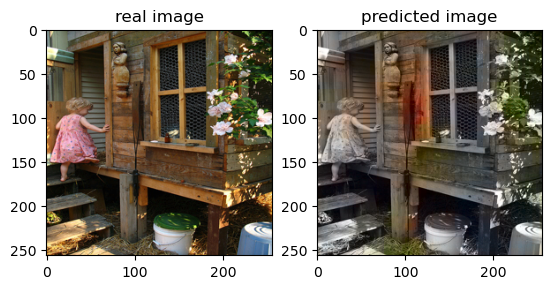

In [20]:
test_L, test_AB = dataset[0]
test_L = np.expand_dims(test_L, axis=0)
real_img = np.concatenate([test_L, test_AB])
real_img = real_img.transpose(1, 2, 0).astype(np.uint8)
real_img = lab2rgb(real_img)

with torch.no_grad():
    model.load_state_dict(
        torch.load("AutoColor.pth", weights_only=True, map_location=device)
    )

    input_tensor = torch.tensor(test_L)
    input_tensor = torch.unsqueeze(input_tensor, dim=0).to(device)
    pred_AB = model(input_tensor)

    pred_LAB = torch.cat([input_tensor, pred_AB], dim=1)
    pred_LAB = torch.squeeze(pred_LAB)
    pred_LAB = pred_LAB.permute(1, 2, 0).cpu().numpy()
    pred_LAB = lab2rgb(pred_LAB.astype(np.uint8))

plt.subplot(1, 2, 1)
plt.imshow(real_img)
plt.title("real image")

plt.subplot(1, 2, 2)
plt.imshow(pred_LAB)
plt.title("predicted image")

plt.show()